In [1]:
"""
Multi-Channel Speech Presence Probability
==============

----------


.. [1] M. Souden, J. Chen, J. Benesty and S. Affes, "Gaussian Model-Based Multichannel Speech Presence Probability,"
    in IEEE Transactions on Audio, Speech, and Language Processing, vol. 18, no. 5, pp. 1072-1077, July 2010,
    doi: 10.1109/TASL.2009.2035150.
   [2] Bagheri, S., Giacobello, D. (2019) Exploiting Multi-Channel Speech Presence Probability in Parametric
    Multi-Channel Wiener Filter. Proc. Interspeech 2019, 101-105, DOI: 10.21437/Interspeech.2019-2665
   [3] M. Souden, J. Chen, J. Benesty and S. Affes,"An Integrated Solution for Online Multichannel Noise Tracking and Reduction,"

"""

import os

import numpy as np
from pesq import pesq
from pystoi.stoi import stoi

import librosa
import matplotlib.pyplot as plt
from DistantSpeech.transform.transform import Transform
from DistantSpeech.beamformer.utils import pmesh, mesh, load_wav, save_audio, load_pcm
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.beamformer.MicArray import MicArray
from DistantSpeech.noise_estimation import NoiseEstimationMCRA, MCRA2, McSppBase

The RT60 is 82 ms
(6, 316761)
(257, 1244, 6)
(257, 1237, 6)


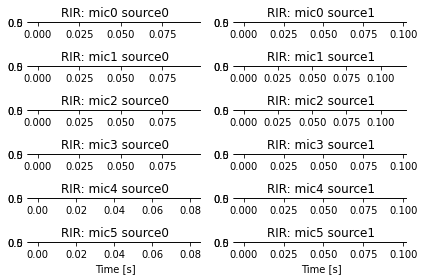

In [2]:


sampling_frequency = 16000
fft_length = 512
fft_shift = 256
mic_diameter = 0.1
sound_speed = 343
look_direction = 30

signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/5_541_20170608093550_3.wav")
# signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3.wav")
noise = audioread("/home/wangwei/work/DistantSpeech/samples/noise/office3.wav")
fs = 16000
M = 6
mic_array = MicArray(arrayType="circular", r=mic_diameter/2, M=M)
mic_array_sim = mic_array.array_sim
# print(mic_array_sim.R)
array_data, premix = mic_array_sim.generate_audio(signal, interference=noise, source_angle=look_direction, interf_angle=270, sir=0, snr=30)
# audiowrite('mix.wav', np.transpose(array_data))
# audiowrite('signal.wav', np.transpose(premix[0, :, :]))
# audiowrite('interf.wav', np.transpose(premix[1, :, :]))

print(array_data.shape)
M = array_data.shape[0]
transform = Transform(n_fft=512, hop_length=256, channel=M)
D = transform.stft(np.transpose(array_data))
target = transform.stft(np.transpose(premix[0, :M, :]))
Noise = transform.stft(np.transpose(premix[1, :M, :]))
print(Noise.shape)
half_bin = D.shape[0]
frame_num = D.shape[1]
print(D.shape)

(257, 1244, 6)
(257, 1237, 6)


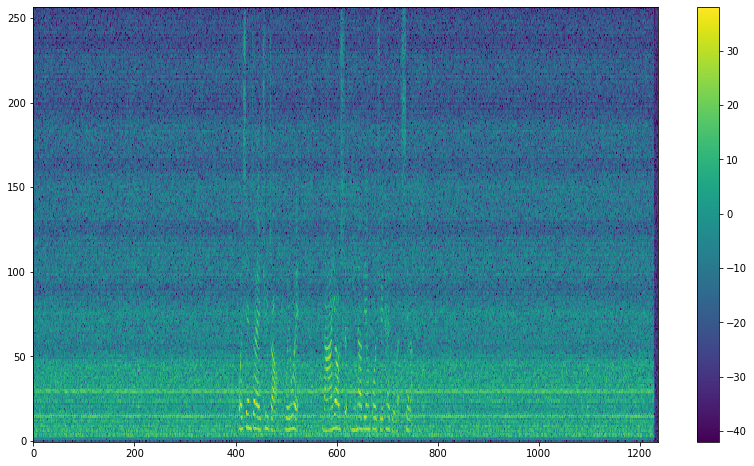

In [3]:

sr = 16000
r = 0.032
c = 343

frameLen = 256
hop = frameLen / 2
overlap = frameLen - hop
nfft = 256
c = 340
r = 0.032
fs = sr

# pampath = '/home/wangwei/work/DistantSpeech/samples/bookself/1'
# # pampath = '/home/wangwei/work/corpus/kws/lanso/record_test/meetingroom/20220106/pcm'
# array_data = load_pcm(pampath)

# wavpath = '/home/wangwei/work/Beamforming-for-speech-enhancement-master/sample_data'
# array_data, _ = load_wav(wavpath)
# array_data = array_data[:M, :]


transform = Transform(n_fft=512, hop_length=256, channel=M)
D = transform.stft(np.transpose(array_data))
Noise = transform.stft(np.transpose(premix[1, ...]))

# D = D[:, :790, :]
# Noise = Noise[:, :790, :]
print(Noise.shape)
Y, _ = transform.magphase(D, 2)
print(Y.shape)
pmesh(librosa.power_to_db(Y[:, :, 0]))
# audiowrite('mix.wav', np.transpose(array_data))
# audiowrite('target.wav', np.transpose(premix[0, :, :]))
# audiowrite('interf.wav', np.transpose(premix[1, :, :]))

In [4]:
channel = M
mcspp = McSppBase(nfft=512, channels=channel)

# override default params
mcspp.mcra.L = 15
mcspp.alpha_d = 0.95
mcspp.alpha = 0.92

p = np.zeros((half_bin, Y.shape[1]))
q = np.zeros((half_bin, Y.shape[1]))

Yout = np.zeros((Y.shape[0], Y.shape[1]), dtype=complex)
Yout1 = np.zeros((Y.shape[0], Y.shape[1]), dtype=complex)
w_n = np.zeros((M, half_bin), dtype=complex)

alpha_xx = mcspp.alpha
alpha_vv = mcspp.alpha
Phi_xx_th = np.zeros((half_bin, M, M), dtype=complex)
Phi_vv_th = np.zeros((half_bin, M, M), dtype=complex)

xi_th = np.zeros((half_bin, Y.shape[1])) # theoretical
xi = np.zeros((half_bin, Y.shape[1])) # estimated
xi_local_th = np.zeros((half_bin, Y.shape[1])) # theoretical

# psd_vv_th_all = np.einsum('ijk,ijl->ijkl', Noise, Noise.conj()) # [half_bin, n_frames,M, M]
diag_bin = np.broadcast_to(np.eye(M) * 1e-6, (half_bin, M, M))

for n in range(Y.shape[1]):
    y = D[:, n, :] #[half_bin, M]

    # theoretical PSD
    noise = Noise[:, n, :] # [M, half_bin]
    target_n = target[:, n, :]
    psd_vv_th = np.einsum('ij,il->ijl', noise, noise.conj()) # half_bin,M,M]
    # psd_vv_th = psd_vv_th_all[:, n,...]
    Phi_vv_th = alpha_vv * Phi_vv_th + (1 - alpha_vv) * psd_vv_th # [half_bin,M,M]

    psd_xx_th = np.einsum('ij,il->ijl', target_n, target_n.conj())
    Phi_xx_th = alpha_xx * Phi_xx_th + (1 - alpha_xx) * psd_xx_th # [M,M,half_bin]

    xi_local_th[:,n] = (np.abs(psd_xx_th[:,0,0])**2)/((np.abs(psd_vv_th[:,0,0])**2)+1e-3)


    Phi_vv_inv_th = np.linalg.inv(Phi_vv_th + diag_bin)
    xi_th[:, n] = np.trace(Phi_vv_inv_th @ Phi_xx_th, axis1=-2, axis2=-1).real

    p[:, n] = mcspp.estimation(y)
    q[:, n] = mcspp.q
    xi[:, n] = mcspp.xi
    mcspp.compute_omlsa_weight(mcspp.xi, mcspp.p)

    Yout[:, n] = y[:, 0]*mcspp.G
    Yout[:, n] = np.sum(y * mcspp.w.conj(), axis=-1)

ValueError: operands could not be broadcast together with shapes (257,6) (6,257) 

In [ ]:
yout = transform.istft(Yout)
yout1 = transform.istft(Yout1)
audiowrite('out4.wav', yout)

In [ ]:
print(xi_local_th[32,250])
pmesh(q)
pmesh((1-q**2)*2)
pmesh(p)

plt.figure(figsize=(14,8))
plt.plot(q[32, :])
plt.plot(p[32, :])
plt.show()

In [ ]:
plt.figure(figsize=(14, 8))

plt.plot(librosa.power_to_db(xi[32,:]), marker="^")
plt.plot(librosa.power_to_db(xi_th[32,:]), marker="+")
plt.xlabel('frame')
plt.ylabel('local SINR/dB')
plt.ylim([-50,50])

plt.legend(['estimated SINR', 'theoretical SINR'])
plt.show()

In [ ]:
print(np.min(xi_local_th))
print(np.max(xi_local_th))

In [ ]:
pmesh(librosa.power_to_db(xi))
pmesh(librosa.power_to_db(xi_th))

In [ ]:
# plt.figure()
# plt.plot(enh)

In [ ]:
nsy = array_data[0, :]
ref = signal
# enh = audioread("/home/wangwei/work/DistantSpeech/samples/noise/office1.wav")
# enh = audioread("/home/wangwei/work/DistantSpeech/example/out2.wav")

enh = yout[256:]
nsy = nsy[: len(enh)]
ref = ref[: len(enh)]

offset = 20480 # skip unconverge segment
enh = enh[offset:]
nsy = nsy[offset:]
ref = ref[offset:]

summary = {
    'ref_pesq_wb': pesq(sr, ref, nsy, 'wb'),
    'enh_pesq_wb': pesq(sr, ref, enh, 'wb'),
    'ref_pesq_nb': pesq(sr, ref, nsy, 'nb'),
    'enh_pesq_nb': pesq(sr, ref, enh, 'nb'),
    'ref_stoi': stoi(ref, nsy, sr, extended=False),
    'enh_stoi': stoi(ref, enh, sr, extended=False),
    'ref_estoi': stoi(ref, nsy, sr, extended=True),
    'enh_estoi': stoi(ref, enh, sr, extended=True),
}
for key in summary.keys():
    print('{}:{}'.format(key, summary[key]))